In [2]:
# === Environmental Setup and Model Architecture ===

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaModel
import numpy as np
from tqdm import tqdm

# Set device (cuda or cpu)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Custom RoBERTa with ordinal classification for truthfulness scoring
class RobertaOrdinalClassifier(nn.Module):
    """
    Uses RoBERTa, a pre-trained and optimized version of META's Bert Model.
    Predefines classificaiton heads for 6 output classes (pants-fire -> true)
    """
    def __init__(self, num_classes=6, dropout=0.3):
        super().__init__()
        self.num_classes = num_classes
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Helper function for unified probability output
def compute_truthfulness_score(class_probs):
    """
    Convert multi-class probabilities to continuous truthfulness score (0.0 to 1.0)
    Calculates expected value of each classification confidence to produce final unified score
    """
    class_values = torch.tensor([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], device=class_probs.device)
    truthfulness = torch.sum(class_probs * class_values, dim=1)
    return truthfulness

print("Libraries imported and model architecture defined")

Using device: cpu
Libraries imported and model architecture defined


In [6]:
# === Dataset Loading and Preperation ===

def load_liar_data(file_path):
    """ Loads LIAR dataset, preselecting labels, statements, subjects, and context columns"""
    
    df = pd.read_csv(
        file_path,
        sep='\t',
        header=None,
        usecols=[1, 2, 3, 13],
        names=['label', 'statement', 'subject', 'context']
    )
    
    # Clean text columns for uniformity
    for col in ['statement', 'subject', 'context']:
        df[col] = df[col].fillna('').astype(str).str.strip()
    
    # Map labels to scalar quantities
    label_map = {
        'pants-fire': 0,
        'false': 1,
        'barely-true': 2,
        'half-true': 3,
        'mostly-true': 4,
        'true': 5
    }
    df['label_encoded'] = df['label'].map(label_map)
    
    return df

# Load test dataset
test_df = load_liar_data('liar_dataset/test.tsv')
print(f"Loaded {len(test_df)} test samples")
print(f"\nLabel distribution:")
print(test_df['label'].value_counts().sort_index())

# Show a few examples
print("\n" + "="*80)
print("SAMPLE STATEMENTS")
print("="*80)

# Randomly select two examples
sample_indices = list(np.random.choice(test_df.index, size=2, replace=False))

# Display examples
for i, idx in enumerate(sample_indices[:2], 1):
    row = test_df.iloc[idx]
    print(f"\nExample {i}:")
    print(f"  Label: {row['label']}")
    print(f"  Statement: {row['statement']}")
    print(f"  Subject: {row['subject']}")
    print(f"  Context: {row['context']}")

Loaded 1267 test samples

Label distribution:
label
barely-true    212
false          249
half-true      265
mostly-true    241
pants-fire      92
true           208
Name: count, dtype: int64

SAMPLE STATEMENTS

Example 1:
  Label: mostly-true
  Statement: The fact of the matter is that my colleague from New York, Senator Clinton, there are 50 percent of the American public that say they're not going to vote for her.
  Subject: elections
  Context: a debate in Philadelphia

Example 2:
  Label: false
  Statement: In the U.S. Constitution, theres a little section in there that talks about life, liberty and the pursuit of happiness.
  Subject: history
  Context: in a speech announcing his presidential run


In [7]:
# === Tokenizer and Model Preperation ===

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
print("Tokenizer loaded")

# Load trained model
model = RobertaOrdinalClassifier(num_classes=6, dropout=0.3)
model.load_state_dict(torch.load('liar_model.pt', map_location=device))
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer loaded


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded and set to evaluation mode


In [8]:
# === Inference and Data Collection ===

def predict_batch(model, statements, subjects, contexts, tokenizer, device, batch_size=32):
    """ Run inference, statements are batched to increase throughput """

    model.eval()
    
    all_truthfulness_scores = []
    all_predicted_classes = []
    all_class_probabilities = []
    
    num_batches = (len(statements) + batch_size - 1) // batch_size
    
    # Inference
    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Running inference"):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(statements))
            
            batch_statements = statements[start_idx:end_idx]
            batch_subjects = subjects[start_idx:end_idx]
            batch_contexts = contexts[start_idx:end_idx]
            
            # Prepare inputs
            input_texts = []
            for stmt, subj, ctx in zip(batch_statements, batch_subjects, batch_contexts):
                if subj and ctx:
                    input_texts.append(f"{stmt} {tokenizer.sep_token} {subj} {tokenizer.sep_token} {ctx}")
                elif subj:
                    input_texts.append(f"{stmt} {tokenizer.sep_token} {subj}")
                else:
                    input_texts.append(stmt)
            
            # Tokenize batch
            encoding = tokenizer(
                input_texts,
                max_length=256,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Data to compute device
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Get predictions
            logits = model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1)
            
            # Compute truthfulness scores
            truthfulness = compute_truthfulness_score(probs)
            
            # Get predicted classes
            predicted = torch.argmax(probs, dim=1)
            
            # Store results
            all_truthfulness_scores.extend(truthfulness.cpu().numpy())
            all_predicted_classes.extend(predicted.cpu().numpy())
            all_class_probabilities.extend(probs.cpu().numpy())
    
    return np.array(all_truthfulness_scores), np.array(all_predicted_classes), np.array(all_class_probabilities)

# Run inference on test set
print("\nRunning inference on test set...")
truthfulness_scores, predicted_classes, class_probabilities = predict_batch(
    model=model,
    statements=test_df['statement'].values,
    subjects=test_df['subject'].values,
    contexts=test_df['context'].values,
    tokenizer=tokenizer,
    device=device,
    batch_size=32
)

# Add results to dataframe
test_df['truthfulness_score'] = truthfulness_scores
test_df['predicted_class'] = predicted_classes

class_names = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
test_df['predicted_label'] = test_df['predicted_class'].map(lambda x: class_names[x])

print("Inference complete")


Running inference on test set...


Running inference: 100%|██████████| 40/40 [02:43<00:00,  4.09s/it]

Inference complete


In [9]:
# === Inference Results ===

print("\n" + "="*80)
print("INFERENCE RESULTS")
print("="*80)

# Overall statistics
print(f"\nTruthfulness Score Statistics:")
print(f"  Mean: {truthfulness_scores.mean():.3f}")
print(f"  Std Dev: {truthfulness_scores.std():.3f}")
print(f"  Min: {truthfulness_scores.min():.3f}")
print(f"  Max: {truthfulness_scores.max():.3f}")
print(f"  Median: {np.median(truthfulness_scores):.3f}")

# Score distribution by true label
print(f"\n\nTruthfulness Score by True Label:")
print(f"{'True Label':<15} {'Mean Score':<12} {'Std Dev':<10} {'Count':<8}")
print("-" * 50)
for label in class_names:
    mask = test_df['label'] == label
    if mask.sum() > 0:
        scores = test_df[mask]['truthfulness_score']
        print(f"{label:<15} {scores.mean():>11.3f} {scores.std():>10.3f} {mask.sum():>8}")

# Show examples with predictions
print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Show the same examples we displayed earlier
for i, idx in enumerate(sample_indices[:2], 1):
    row = test_df.loc[idx]
    print(f"\nExample {i}:")
    print(f"  Statement: {row['statement'][:150]}...")
    print(f"  Subject: {row['subject']}")
    print(f"  True Label: {row['label']}")
    print(f"  Predicted Label: {row['predicted_label']}")
    print(f"  Truthfulness Score: {row['truthfulness_score']:.3f}")
    print(f"  Class Probabilities:")
    probs = class_probabilities[idx]
    for class_idx, (class_name, prob) in enumerate(zip(class_names, probs)):
        bar = '█' * int(prob * 20)
        print(f"    {class_name:15s} {prob:.3f} {bar}")

# Accuracy metrics
print("\n" + "="*80)
print("ACCURACY METRICS")
print("="*80)

# Exact accuracy
exact_accuracy = (test_df['predicted_class'] == test_df['label_encoded']).mean()
print(f"\nExact Match Accuracy: {exact_accuracy:.4f} ({exact_accuracy*100:.2f}%)")

# Off-by-one accuracy
off_by_1 = (np.abs(test_df['predicted_class'] - test_df['label_encoded']) <= 1).mean()
print(f"Within ±1 Class: {off_by_1:.4f} ({off_by_1*100:.2f}%)")

# Off-by-two accuracy
off_by_2 = (np.abs(test_df['predicted_class'] - test_df['label_encoded']) <= 2).mean()
print(f"Within ±2 Classes: {off_by_2:.4f} ({off_by_2*100:.2f}%)")

# Show distribution across score ranges
print("\n\nDistribution of Predictions by Score Range:")
ranges = [(0.0, 0.2, "Highly False"), (0.2, 0.4, "Likely False"), 
          (0.4, 0.6, "Uncertain"), (0.6, 0.8, "Likely True"), 
          (0.8, 1.0, "Highly True")]

for low, high, label in ranges:
    count = ((truthfulness_scores >= low) & (truthfulness_scores < high)).sum()
    pct = count / len(truthfulness_scores) * 100
    bar = '█' * int(pct / 2)
    print(f"  {label:15s} [{low:.1f}-{high:.1f}]: {count:4d} ({pct:5.1f}%) {bar}")

# Save results
output_file = 'test_predictions_with_scores.csv'
test_df[['statement', 'subject', 'context', 'label', 'predicted_label', 
         'truthfulness_score']].to_csv(output_file, index=False)
print(f"\nResults saved to '{output_file}'")



INFERENCE RESULTS

Truthfulness Score Statistics:
  Mean: 0.514
  Std Dev: 0.187
  Min: 0.041
  Max: 0.880
  Median: 0.546


Truthfulness Score by True Label:
True Label      Mean Score   Std Dev    Count   
--------------------------------------------------
pants-fire            0.320      0.218       92
false                 0.466      0.180      249
barely-true           0.472      0.172      212
half-true             0.519      0.171      265
mostly-true           0.599      0.144      241
true                  0.595      0.165      208

SAMPLE PREDICTIONS

Example 1:
  Statement: When asked by a reporter whether hes at the center of a criminal scheme to violate campaign laws, Gov. Scott Walker nodded yes....
  Subject: campaign-finance,legal-issues,campaign-advertising
  True Label: pants-fire
  Predicted Label: false
  Truthfulness Score: 0.487
  Class Probabilities:
    pants-fire      0.111 ██
    false           0.310 ██████
    barely-true     0.117 ██
    half-true       0.



INGRESS GATE SYSTEM

Gate Decision Distribution:
gate_decision
review    650
allow     361
reject    256
Name: count, dtype: int64


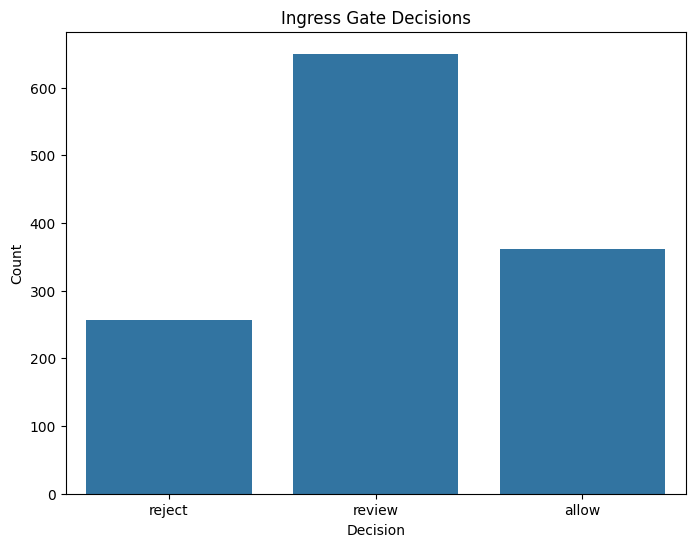

CSV files successfully created:
 - accepted.csv  (gate = allow)
 - review.csv    (gate = review)
 - rejected.csv  (gate = reject)

Counts:
gate_decision
review    650
allow     361
reject    256
Name: count, dtype: int64

Examples per gate decision:

---- REJECT ----
Statement: Suzanne Bonamici supports a plan that will cut choice for Medicare Advantage seniors.
True Label: half-true
Predicted: pants-fire
Score: 0.258

---- REVIEW ----
Statement: Building a wall on the U.S.-Mexico border will take literally years.
True Label: true
Predicted: false
Score: 0.354

---- ALLOW ----
Statement: Over the past five years the federal government has paid out $601 million in retirement and disability benefits to deceased former federal employees.
True Label: true
Predicted: true
Score: 0.745


In [ ]:
# Ingress Gate 
import matplotlib.pyplot as plt
import seaborn as sns
print("\n\n" + "="*80)
print("INGRESS GATE SYSTEM")
print("="*80)

class IngressGate:
    """
    Simple ingress gate based on truthfulness score.
    Scores near 0 → false, near 1 → true.
    """

    def __init__(self, threshold_low=0.35, threshold_high=0.65):
        """
        threshold_low  : below → reject as likely false
        threshold_high : above → allow as likely true
        values between → 'review'
        """
        self.threshold_low = threshold_low
        self.threshold_high = threshold_high

    def evaluate(self, score):
        if score < self.threshold_low:
            return "reject"
        elif score >= self.threshold_high:
            return "allow"
        return "review"  # uncertainty zone

# Instantiate gate
gate = IngressGate(threshold_low=0.35, threshold_high=0.65)

# Apply gate to test set
gate_results = [gate.evaluate(s) for s in truthfulness_scores]
test_df["gate_decision"] = gate_results

# Summary
print("\nGate Decision Distribution:")
print(test_df["gate_decision"].value_counts())

# Visualization
plt.figure(figsize=(8,6))
sns.countplot(data=test_df, x="gate_decision", order=["reject", "review", "allow"])
plt.title("Ingress Gate Decisions")
plt.xlabel("Decision")
plt.ylabel("Count")
plt.show()

# === Export Ingress Gate Buckets to CSV ===

# Ensure the decision column exists
if "gate_decision" not in test_df.columns:
    raise ValueError("gate_decision column not found. Run the Ingress Gate section first.")

# Create subsets
accepted_df = test_df[test_df["gate_decision"] == "allow"]
review_df   = test_df[test_df["gate_decision"] == "review"]
rejected_df = test_df[test_df["gate_decision"] == "reject"]

# Export each to CSV
accepted_df.to_csv("accepted.csv", index=False)
review_df.to_csv("review.csv", index=False)
rejected_df.to_csv("rejected.csv", index=False)

print("CSV files successfully created:")
print(" - accepted.csv  (gate = allow)")
print(" - review.csv    (gate = review)")
print(" - rejected.csv  (gate = reject)")
print("\nCounts:")
print(test_df['gate_decision'].value_counts())

# Show examples for each gate category
print("\nExamples per gate decision:")
for decision in ["reject", "review", "allow"]:
    example = test_df[test_df["gate_decision"] == decision].iloc[0]
    print("\n----", decision.upper(), "----")
    print("Statement:", example["statement"])
    print("True Label:", example["label"])
    print("Predicted:", example["predicted_label"])
    print("Score:", round(example["truthfulness_score"], 3))



VISUALIZATIONS


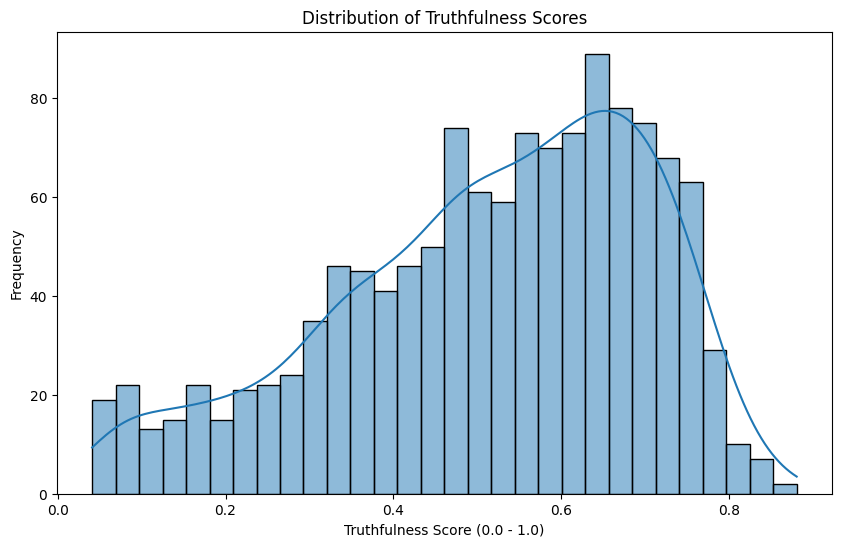

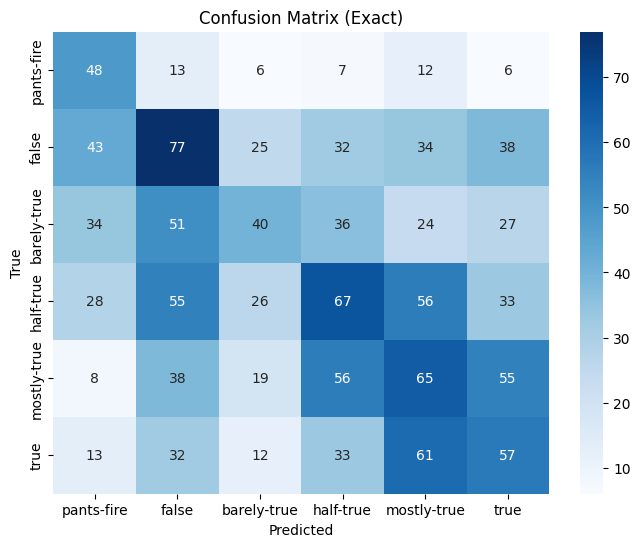

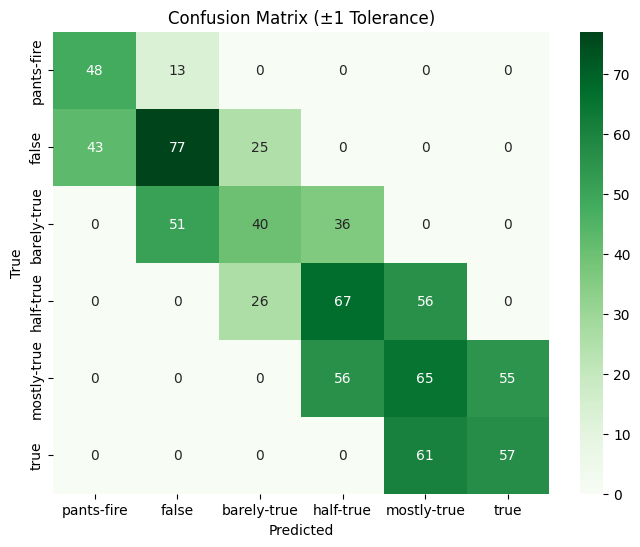

In [12]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n\n" + "="*80)
print("VISUALIZATIONS")
print("="*80)

# Histogram of truthfulness scores

plt.figure(figsize=(10, 6))
sns.histplot(truthfulness_scores, bins=30, kde=True)
plt.title("Distribution of Truthfulness Scores")
plt.xlabel("Truthfulness Score (0.0 - 1.0)")
plt.ylabel("Frequency")
plt.show()


# Confusion matrix (exact)

y_true = test_df['label_encoded'].values
y_pred = test_df['predicted_class'].values
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d',
    xticklabels=class_names, yticklabels=class_names,
    cmap="Blues"
)
plt.title("Confusion Matrix (Exact)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Off-by-1 tolerant confusion matrix

cm_off1 = np.zeros_like(cm)
for i in range(6):
    for j in range(6):
        if abs(i - j) <= 1:
            cm_off1[i, j] = cm[i, j]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_off1, annot=True, fmt='d',
    xticklabels=class_names, yticklabels=class_names,
    cmap="Greens"
)
plt.title("Confusion Matrix (±1 Tolerance)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()